In [249]:
import os
import pandas as pd

res_path = '/home/gabi/diplomka/results/'
base_names = ['labeled_train', 'labeled_valid_unseen_networks-val_loss', 'labeled_valid_unseen_images-val_loss']

def process_res_directory(dir_path: str, with_baselines=True):
    loss_df = pd.read_csv(os.path.join(dir_path, 'loss.csv'), index_col=0)
    labeled_train = loss_df[['labeled_labeled']]
    unlabeled_train = loss_df[['labeled_unlabeled']]
    ununlabeled_train = loss_df[['unlabeled_unlabeled']]
    
    metrics_df = pd.read_csv(os.path.join(dir_path, 'metrics.csv'), index_col=0)
    metric_cols = [c for c in metrics_df.columns if 'unseen' in c]
    
    labeled_val = metrics_df[metric_cols]
                            
    res_df = pd.concat([labeled_train, unlabeled_train, ununlabeled_train, labeled_val], axis=1)
    res_df.reset_index(inplace=True)
    
    exp_name = dir_path.split('/')[-3]
    res_df.insert(0, 'exp_name', exp_name)
    
    if with_baselines:
        baselines = {}
        base_files = ['train_long_baseline.csv', 'valid_long_baseline.csv', 'test_small_split_baseline.csv']
        for name, baseline in zip(base_names, base_files):
            baseline_path = os.path.join(dir_path, baseline)
            base_df = pd.read_csv(baseline_path, index_col=0)

            baselines[name] = base_df

        return exp_name, res_df, baselines
    
    return exp_name, res_df

In [250]:
import glob

dfs = []
baseline_dict = {}

for dir_p in glob.glob(os.path.join(res_path, 'model_config*/2021-19-07_13*/')):
    name, res, base = process_res_directory(dir_p)
    
    dfs.append(res)
    baseline_dict[name] = base
    
dfs = pd.concat(dfs)

In [251]:
dfs

,exp_name,index,labeled_labeled,labeled_unlabeled,unlabeled_unlabeled,labeled_valid_unseen_networks-val_loss,labeled_valid_unseen_networks-MSE,labeled_valid_unseen_networks-L1,labeled_valid_unseen_networks-val_loss_min,labeled_valid_unseen_networks-val_loss_max,labeled_valid_unseen_networks-val_loss_std,labeled_valid_unseen_networks-val_loss_median,labeled_valid_unseen_images-val_loss,labeled_valid_unseen_images-MSE,labeled_valid_unseen_images-L1,labeled_valid_unseen_images-val_loss_min,labeled_valid_unseen_images-val_loss_max,labeled_valid_unseen_images-val_loss_std,labeled_valid_unseen_images-val_loss_median
0,model_config_axis-0_weighted-false_mult-false....,1,0.001750,0.279247,0.292031,0.001597,0.003152,0.001597,0.000488,0.004537,0.000544,0.001540,0.001824,0.004916,0.001824,0.000513,0.008763,0.000746,0.001704
1,model_config_axis-0_weighted-false_mult-false....,2,0.001694,0.225582,0.240806,0.001603,0.003151,0.001603,0.000493,0.004542,0.000544,0.001547,0.001830,0.004913,0.001830,0.000518,0.008766,0.000746,0.001709
2,model_config_axis-0_weighted-false_mult-false....,3,0.001697,0.221082,0.236069,0.001606,0.003149,0.001606,0.000496,0.004544,0.000544,0.001550,0.001832,0.004910,0.001832,0.000520,0.008764,0.000745,0.001712
3,model_config_axis-0_weighted-false_mult-false....,4,0.001698,0.219029,0.233922,0.001610,0.003138,0.001610,0.000497,0.004541,0.000542,0.001556,0.001830,0.004881,0.001830,0.000516,0.008733,0.000740,0.001710
4,model_config_axis-0_weighted-false_mult-false....,5,0.001699,0.217621,0.232025,0.001607,0.003157,0.001607,0.000499,0.004550,0.000545,0.001553,0.001836,0.004929,0.001836,0.000527,0.008788,0.000748,0.001715
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25,model_config_vae-1e-4_labeled-50.json,26,9.397394,0.000061,0.280233,17.958567,0.244520,0.359171,4.117178,62.545532,13.158021,12.494215,8.311532,0.098895,0.166231,3.372877,42.055122,4.692449,7.579239
26,model_config_vae-1e-4_labeled-50.json,27,9.370848,0.000061,0.281006,19.527774,0.272475,0.390555,4.406863,67.447891,13.720169,13.859815,8.736162,0.105297,0.174723,4.146539,49.127815,5.651637,7.772602
27,model_config_vae-1e-4_labeled-50.json,28,9.321326,0.000061,0.281697,19.793933,0.275088,0.395879,4.455978,62.060486,13.466444,15.474792,8.629489,0.105703,0.172590,3.448659,46.894268,5.480820,7.542125
28,model_config_vae-1e-4_labeled-50.json,29,9.409053,0.000063,0.281907,19.096988,0.282985,0.381940,3.823196,87.271408,15.081030,13.859608,9.114101,0.108266,0.182282,4.501535,46.824123,5.676363,7.805134


In [260]:
def get_comparison_for_epoch(full_df, reference, epoch):
    preserve_columns = ['labeled_unlabeled', 'labeled_labeled', 'unlabeled_unlabeled', 'exp_name', 'index']
    columns = [c for c in full_df.columns if 'val_loss' in c or c in preserve_columns]
    
    filtered_df = full_df[columns]
    filtered_df = filtered_df[filtered_df['index'] == epoch].reset_index(drop=True)
    res_df = []
    
    for i, exp_name in enumerate(filtered_df['exp_name']):
        res_entry = {}
        
        if 'vae' in exp_name:
            vae = exp_name[17:21]
            vae = 1.0 if '1.0' in vae else float(vae)
            labeled = float(exp_name[29:31].replace('-', ''))
            
            if labeled == 0:
                labeled = 0.5
            elif labeled == 5:
                labeled = 50.0
            
            res_entry['labeled_labeled_scaled'] = filtered_df.iloc[i]['labeled_labeled'] / labeled
            res_entry['labeled_unlabeled_scaled'] = filtered_df.iloc[i]['labeled_unlabeled'] / vae
            for c in filtered_df.columns:
                if 'labeled_valid' not in c or 'name' in c:
                    continue
                res_entry[f"{c}_scaled"] = filtered_df.iloc[i][c] / labeled
        else:
            labeled = 1.0
        
        exp_ref = reference[exp_name]
        for b in base_names:
            b_df = exp_ref[b]
                        
            use_id = 0 if 'MSE' in exp_name else 1
            res_entry.update({f"{b}_{k}_ref": v for k, v in b_df.iloc[use_id].iteritems()})
            
            
        res_df.append(res_entry)
    
    res_df = pd.DataFrame(res_df)
    res_df = pd.concat([filtered_df, res_df], axis=1)
    res_df = res_df.reindex(sorted(res_df.columns), axis=1)
    return res_df

In [261]:
i = 8
rd = get_comparison_for_epoch(dfs, baseline_dict, i).round(8)
rd.to_csv(f'expe_data/epoch_{i}_w_baselines.csv')

In [254]:
rd.reindex(sorted(rd.columns), axis=1)

,exp_name,index,labeled_labeled,labeled_labeled_scaled,labeled_train_loss_name_ref,labeled_train_max_ref,labeled_train_mean_ref,labeled_train_median_ref,labeled_train_min_ref,labeled_train_std_ref,...,labeled_valid_unseen_networks-val_loss_median_ref,labeled_valid_unseen_networks-val_loss_median_scaled,labeled_valid_unseen_networks-val_loss_min,labeled_valid_unseen_networks-val_loss_min_ref,labeled_valid_unseen_networks-val_loss_min_scaled,labeled_valid_unseen_networks-val_loss_scaled,labeled_valid_unseen_networks-val_loss_std,labeled_valid_unseen_networks-val_loss_std_ref,labeled_valid_unseen_networks-val_loss_std_scaled,unlabeled_unlabeled
0,model_config_axis-0_weighted-false_mult-false....,8,0.001701,NaN,L1,0.006104,0.001659,0.001606,0.000776,0.000375,...,0.001488,NaN,0.000501,0.000423,NaN,NaN,0.000545,0.000518,NaN,0.229169
1,model_config_axis-0_weighted-false_mult-true.json,8,0.043637,NaN,L1,0.095878,0.085476,0.085298,0.078573,0.002384,...,117.517487,NaN,0.033217,117.509260,NaN,NaN,783.484893,779.903502,NaN,0.230885
2,model_config_axis-0_weighted-true_mult-true.json,8,0.647399,NaN,L1,1.626011,0.713126,0.703105,0.594080,0.055006,...,0.693630,NaN,0.327478,0.443386,NaN,NaN,0.084791,0.075277,NaN,0.226616
3,model_config_axis-null_weighted-false_mult-fal...,8,1.835072,NaN,L1,4.564875,2.091181,2.060045,1.659586,0.174519,...,2.064780,NaN,0.738420,1.193783,NaN,NaN,0.290472,0.245332,NaN,0.227993
4,model_config_axis-null_weighted-false_mult-tru...,8,0.181473,NaN,L1,1.209878,0.765579,0.761163,0.412319,0.106959,...,0.511811,NaN,0.089180,0.105278,NaN,NaN,0.277119,0.525986,NaN,0.235550
5,model_config_axis-null_weighted-true_mult-true...,8,0.551957,NaN,L1,1.762504,0.669126,0.657735,0.560062,0.063046,...,0.658170,NaN,0.325327,0.457067,NaN,NaN,0.100253,0.101525,NaN,0.228469
6,model_config_loss-L1_lr-1e-2.json,8,0.754154,NaN,L1,1.209878,0.765579,0.761163,0.412319,0.106959,...,0.511811,NaN,0.107761,0.105278,NaN,NaN,0.566948,0.525986,NaN,0.261052
7,model_config_loss-L1_lr-1e-3.json,8,0.181802,NaN,L1,1.209878,0.765579,0.761163,0.412319,0.106959,...,0.511811,NaN,0.088362,0.105278,NaN,NaN,0.314118,0.525986,NaN,0.238875
8,model_config_loss-L1_lr-1e-4.json,8,0.177141,NaN,L1,1.209878,0.765579,0.761163,0.412319,0.106959,...,0.511811,NaN,0.091554,0.105278,NaN,NaN,0.350672,0.525986,NaN,0.229335
9,model_config_loss-MSE_lr-1e-2.json,8,0.283606,NaN,MSE,2.707990,1.000185,0.962370,0.314191,0.289896,...,0.304573,NaN,0.030062,0.037128,NaN,NaN,0.450584,1.126022,NaN,0.276906


In [255]:
sorted(rd.columns)

['exp_name',
 'index',
 'labeled_labeled',
 'labeled_labeled_scaled',
 'labeled_train_loss_name_ref',
 'labeled_train_max_ref',
 'labeled_train_mean_ref',
 'labeled_train_median_ref',
 'labeled_train_min_ref',
 'labeled_train_std_ref',
 'labeled_unlabeled',
 'labeled_unlabeled_scaled',
 'labeled_valid_unseen_images-val_loss',
 'labeled_valid_unseen_images-val_loss_loss_name_ref',
 'labeled_valid_unseen_images-val_loss_max',
 'labeled_valid_unseen_images-val_loss_max_ref',
 'labeled_valid_unseen_images-val_loss_max_scaled',
 'labeled_valid_unseen_images-val_loss_mean_ref',
 'labeled_valid_unseen_images-val_loss_median',
 'labeled_valid_unseen_images-val_loss_median_ref',
 'labeled_valid_unseen_images-val_loss_median_scaled',
 'labeled_valid_unseen_images-val_loss_min',
 'labeled_valid_unseen_images-val_loss_min_ref',
 'labeled_valid_unseen_images-val_loss_min_scaled',
 'labeled_valid_unseen_images-val_loss_scaled',
 'labeled_valid_unseen_images-val_loss_std',
 'labeled_valid_unseen_imag

In [214]:
im_paths = glob.glob(os.path.join(res_path, 'model_config_loss-MSE_lr-1e-4.json/*/'))
im_paths

['/home/gabi/diplomka/results/model_config_loss-MSE_lr-1e-4.json/2021-19-07_13-01-12/',
 '/home/gabi/diplomka/results/model_config_loss-MSE_lr-1e-4.json/2021-19-07_19-52-14/']

In [215]:
im1_name, im1_res, base = process_res_directory(im_paths[0])
im2_name, im2_res = process_res_directory(im_paths[1], with_baselines=False)

In [216]:
base

{'labeled_train':   loss_name      mean       std       min       max    median
 0       MSE  1.000185  0.289896  0.314191  2.707990  0.962370
 1        L1  0.765579  0.106959  0.412319  1.209878  0.761163
 2     Huber  0.407250  0.089773  0.151409  0.813649  0.401320,
 'labeled_valid_unseen_networks-val_loss':   loss_name      mean       std       min       max    median
 0       MSE  0.834597  1.126022  0.037128  6.101653  0.304573
 1        L1  0.710611  0.525986  0.105278  2.441400  0.511811
 2     Huber  0.359268  0.425021  0.018274  1.943842  0.148049,
 'labeled_valid_unseen_images-val_loss':   loss_name      mean       std       min       max    median
 0       MSE  0.958540  0.337582  0.292087  2.829140  0.905116
 1        L1  0.725408  0.108752  0.441126  1.138974  0.717286
 2     Huber  0.375167  0.093793  0.142421  0.734999  0.367203}

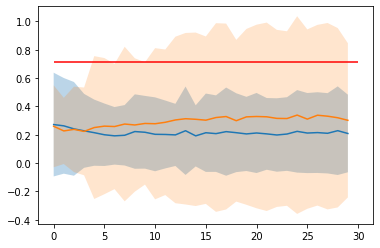

In [217]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

val_loss = im1_res['labeled_valid_unseen_networks-val_loss']
val_loss_std = im1_res['labeled_valid_unseen_networks-val_loss_std']
val_loss2 = im2_res['labeled_valid_unseen_networks-val_loss']
val_loss2_std = im2_res['labeled_valid_unseen_networks-val_loss_std']
val_base = base['labeled_valid_unseen_networks-val_loss'].iloc[1]['mean']
val_base_std = base['labeled_valid_unseen_networks-val_loss'].iloc[1]['std']

plt.figure()
plt.plot(val_loss)
plt.fill_between(np.arange(len(val_loss)), val_loss + val_loss_std, val_loss - val_loss_std, alpha=0.3)
plt.plot(val_loss2)
plt.fill_between(np.arange(len(val_loss2)), val_loss2 + val_loss2_std, val_loss2 - val_loss2_std, alpha=0.2)
plt.hlines(val_base, 0, len(val_loss), colors='r')
plt.show()

In [204]:
im_paths = glob.glob(os.path.join(res_path, 'model_config_loss-L1_lr-1e-3.json/*/'))

im1_name, im1_res, base = process_res_directory(im_paths[0])
im2_name, im2_res = process_res_directory(im_paths[1], with_baselines=False)

im_paths

['/home/gabi/diplomka/results/model_config_loss-L1_lr-1e-3.json/2021-19-07_13-01-39/',
 '/home/gabi/diplomka/results/model_config_loss-L1_lr-1e-3.json/2021-19-07_19-52-21/']

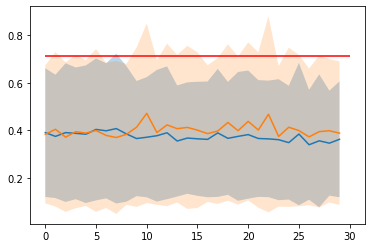

In [205]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

val_loss = im1_res['labeled_valid_unseen_networks-val_loss']
val_loss_std = im1_res['labeled_valid_unseen_networks-val_loss_std']
val_loss2 = im2_res['labeled_valid_unseen_networks-val_loss']
val_loss2_std = im2_res['labeled_valid_unseen_networks-val_loss_std']
val_base = base['labeled_valid_unseen_networks-val_loss'].iloc[1]['mean']
val_base_std = base['labeled_valid_unseen_networks-val_loss'].iloc[1]['std']

plt.figure()
plt.plot(val_loss)
plt.fill_between(np.arange(len(val_loss)), val_loss + val_loss_std, val_loss - val_loss_std, alpha=0.3)
plt.plot(val_loss2)
plt.fill_between(np.arange(len(val_loss2)), val_loss2 + val_loss2_std, val_loss2 - val_loss2_std, alpha=0.2)
plt.hlines(val_base, 0, len(val_loss), colors='r')
plt.show()

In [262]:
rd8 = get_comparison_for_epoch(dfs, baseline_dict, 8)
rd20 = get_comparison_for_epoch(dfs, baseline_dict, 20)
rd30 = get_comparison_for_epoch(dfs, baseline_dict, 30)

In [263]:
train_samples = 608000
val_samples = 77000
test_samples = 122000

def ci_95(std, sample_size):
    return 1.96 * std / np.sqrt(sample_size)

In [298]:
def replace_with_scaled(df, normal_column_name, scaled_column):
    for i, val in scaled_column.iteritems():
        if not pd.isna(val):
            print(i)
            df.loc[i, normal_column_name] = val


def get_epoch_stats_train(rd):
    lossn = 'labeled_valid_unseen_images-val_loss_loss_name_ref'
    mean_train = rd[['exp_name', lossn, 'labeled_labeled', 'labeled_train_mean_ref']].copy()
    ci_ref = ci_95(rd['labeled_train_std_ref'], train_samples)
    mean_train['ci'] = ci_ref
    
    mean_train.columns = [(c if c != lossn else 'loss name') for c in mean_train.columns]
    
    replace_with_scaled(mean_train, 'labeled_labeled', rd['labeled_labeled_scaled'])
    
    return mean_train

def get_epoch_stats_val(rd, name, samples, new_name):
    mean_val = rd[f'{name}']
    mean_ref = rd[f'{name}_mean_ref']
    ci = ci_95(rd[f'{name}_std'], samples)
    ci_ref = ci_95(rd[f'{name}_std_ref'], samples)
    
    df = pd.concat([mean_val, ci, mean_ref, ci_ref], axis=1)
    df.columns = [f"{new_name}_mean", f"{new_name}_ci", f"{new_name}_mean_ref", f"{new_name}_ci_ref"]
    
    replace_with_scaled(df, f'{new_name}_mean', rd[f'{name}_scaled'])
    
    return df
   
in_rd = rd8
res = get_epoch_stats_train(in_rd)
resv = get_epoch_stats_val(in_rd, 'labeled_valid_unseen_networks-val_loss', val_samples, 'unseen_networks')
rest = get_epoch_stats_val(in_rd, 'labeled_valid_unseen_images-val_loss', test_samples, 'unseen_images')
res = pd.concat([res, resv, rest], axis=1).round(6)
print(' '.join([w for w in res.to_latex(index=False).split(' ') if len(w)]))
res

12
13
14
15
16
17
18
19
20
21
22
23
12
13
14
15
16
17
18
19
20
21
22
23
12
13
14
15
16
17
18
19
20
21
22
23
\begin{tabular}{llrrrrrrrrrrr}
\toprule
 exp\_name & loss name & labeled\_labeled & labeled\_train\_mean\_ref & ci & unseen\_networks\_mean & unseen\_networks\_ci & unseen\_networks\_mean\_ref & unseen\_networks\_ci\_ref & unseen\_images\_mean & unseen\_images\_ci & unseen\_images\_mean\_ref & unseen\_images\_ci\_ref \\
\midrule
model\_config\_axis-0\_weighted-false\_mult-false.json & L1 & 0.001701 & 0.001659 & 0.000001 & 0.001609 & 0.000004 & 0.001555 & 0.000004 & 0.001838 & 0.000004 & 0.001806 & 0.000002 \\
 model\_config\_axis-0\_weighted-false\_mult-true.json & L1 & 0.043637 & 0.085476 & 0.000006 & 117.441794 & 5.534028 & 234.380416 & 5.508731 & 0.044785 & 0.000043 & 0.087678 & 0.000014 \\
 model\_config\_axis-0\_weighted-true\_mult-true.json & L1 & 0.647399 & 0.713126 & 0.000138 & 0.663696 & 0.000599 & 0.697995 & 0.000532 & 0.733104 & 0.000663 & 0.770672 & 0.000341 \\
model\

,exp_name,loss name,labeled_labeled,labeled_train_mean_ref,ci,unseen_networks_mean,unseen_networks_ci,unseen_networks_mean_ref,unseen_networks_ci_ref,unseen_images_mean,unseen_images_ci,unseen_images_mean_ref,unseen_images_ci_ref
0,model_config_axis-0_weighted-false_mult-false....,L1,0.001701,0.001659,0.000001,0.001609,0.000004,0.001555,0.000004,0.001838,0.000004,0.001806,0.000002
1,model_config_axis-0_weighted-false_mult-true.json,L1,0.043637,0.085476,0.000006,117.441794,5.534028,234.380416,5.508731,0.044785,0.000043,0.087678,0.000014
2,model_config_axis-0_weighted-true_mult-true.json,L1,0.647399,0.713126,0.000138,0.663696,0.000599,0.697995,0.000532,0.733104,0.000663,0.770672,0.000341
3,model_config_axis-null_weighted-false_mult-fal...,L1,1.835072,2.091181,0.000439,1.946470,0.002052,2.069566,0.001733,2.103649,0.002379,2.257200,0.001107
4,model_config_axis-null_weighted-false_mult-tru...,L1,0.181473,0.765579,0.000269,0.382393,0.001957,0.710611,0.003715,0.210620,0.000827,0.725408,0.000610
5,model_config_axis-null_weighted-true_mult-true...,L1,0.551957,0.669126,0.000158,0.601236,0.000708,0.671720,0.000717,0.646328,0.000779,0.740403,0.000395
6,model_config_loss-L1_lr-1e-2.json,L1,0.754154,0.765579,0.000269,0.704586,0.004005,0.710611,0.003715,0.725560,0.003435,0.725408,0.000610
7,model_config_loss-L1_lr-1e-3.json,L1,0.181802,0.765579,0.000269,0.407971,0.002219,0.710611,0.003715,0.229195,0.000929,0.725408,0.000610
8,model_config_loss-L1_lr-1e-4.json,L1,0.177141,0.765579,0.000269,0.416477,0.002477,0.710611,0.003715,0.136863,0.000197,0.725408,0.000610
9,model_config_loss-MSE_lr-1e-2.json,MSE,0.283606,1.000185,0.000729,0.360258,0.003183,0.834597,0.007953,0.339956,0.003457,0.958540,0.001894


In [292]:
for i, a in rd8['labeled_valid_unseen_images-val_loss'].iteritems():
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23


In [236]:
rd8.columns

Index(['exp_name', 'index', 'labeled_labeled', 'labeled_train_loss_name_ref',
       'labeled_train_max_ref', 'labeled_train_mean_ref',
       'labeled_train_median_ref', 'labeled_train_min_ref',
       'labeled_train_std_ref', 'labeled_unlabeled',
       'labeled_unlabeled_scaled', 'labeled_valid_unseen_images-val_loss',
       'labeled_valid_unseen_images-val_loss_loss_name_ref',
       'labeled_valid_unseen_images-val_loss_max',
       'labeled_valid_unseen_images-val_loss_max_ref',
       'labeled_valid_unseen_images-val_loss_max_scaled',
       'labeled_valid_unseen_images-val_loss_mean_ref',
       'labeled_valid_unseen_images-val_loss_median',
       'labeled_valid_unseen_images-val_loss_median_ref',
       'labeled_valid_unseen_images-val_loss_median_scaled',
       'labeled_valid_unseen_images-val_loss_min',
       'labeled_valid_unseen_images-val_loss_min_ref',
       'labeled_valid_unseen_images-val_loss_min_scaled',
       'labeled_valid_unseen_images-val_loss_scaled',
    